In [20]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

In [5]:
CWRU_X_0 = np.load("/data/home/jkataok1/DA_DFD/data/processed/CWRU/0.npz")["x"]
CWRU_X_1 = np.load("/data/home/jkataok1/DA_DFD/data/processed/CWRU/1.npz")["x"]
CWRU_X_2 = np.load("/data/home/jkataok1/DA_DFD/data/processed/CWRU/2.npz")["x"]
CWRU_X_3 = np.load("/data/home/jkataok1/DA_DFD/data/processed/CWRU/3.npz")["x"]
CWRU_X_all = np.load("/data/home/jkataok1/DA_DFD/data/processed/CWRU/3.npz")["x"]
IMS_X_0 = np.load("/data/home/jkataok1/DA_DFD/data/processed/IMS/0.npz")["x"]

In [12]:
print("IMS dataset")
print("Number of samples:", IMS_X_0.shape[0])
print("Length:", IMS_X_0.shape[-1])

IMS dataset
Number of samples: 30000
Length: 2048


In [17]:
ims_embed = TSNE(n_components=2).fit_transform(X=IMS_X_0.reshape(IMS_X_0.shape[0], -1))

/data/home/jkataok1/mlenv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/data/home/jkataok1/mlenv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


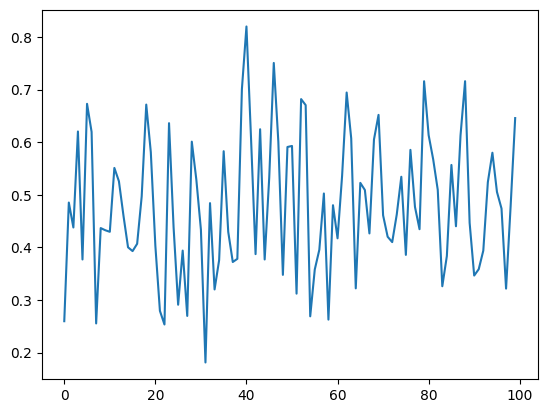

In [29]:
ims = IMS_X_0[0, 0, :]
plt.plot(ims[:100])

In [32]:
cs = CubicSpline(np.arange(0, 2048), ims)
xs = np.arange(0, 2048, 0.1)
cs_xs = cs(xs)

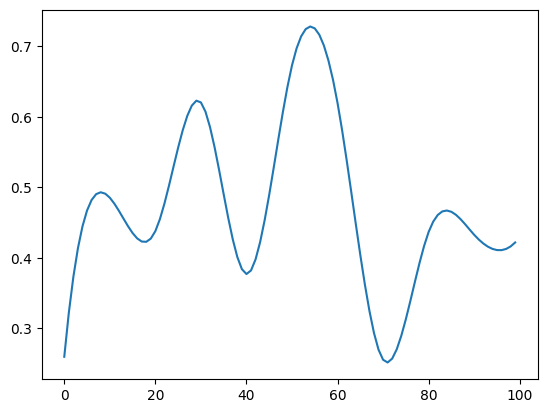

In [38]:

plt.plot(ims[:1000], label="cubic spline")
plt.plot(cs_xs[:100], label="cubic spline")